# Clustering

Unsupervised learning for document similarity.

## _k_-means

About the simplest approach to clustering:

* Set the number of clusters, _k_
* Randomly initiailize _k_ centroids
* Calculate the distance from each centroid to each data point
* Assign each point to the centroid nearest it
* Calculate the centroid of each resulting cluster
* Repeat until cluster assignments do not change

In [1]:
import os
import sys
import nltk
import unicodedata
import numpy as np

from itertools import groupby
from operator import itemgetter
from nltk.corpus import wordnet as wn
from nltk.cluster import KMeansClusterer

# Where are the corpus texts on your system
text_dir = os.path.join('..', 'data', 'texts')
pickle_dir = os.path.join('..', 'data', 'pickled')
pkl_chk_dir = os.path.join('..', 'data', 'pickled_chunked')

# Import our libraries
sys.path.append(os.path.join('..', 'libraries'))
from TMN import PickledCorpusReader


STOPWORDS = set(nltk.corpus.stopwords.words('english'))
lemmatizer = nltk.WordNetLemmatizer()

def is_punct(token):
    # Is every character punctuation?
    return all(
        unicodedata.category(char).startswith('P')
        for char in token
    )


def wnpos(tag):
    # Return the WordNet POS tag from the Penn Treebank tag
    return {
        'N': wn.NOUN,
        'V': wn.VERB,
        'R': wn.ADV,
        'J': wn.ADJ
    }.get(tag[0], wn.NOUN)


def normalize(document, stopwords=STOPWORDS):
    """
    Takes a document = list of (token, pos_tag) tuples
    Removes stopwords and punctuation, lowercases, lemmatizes
    """

    for token, tag in document:
        token = token.lower().strip()

        if is_punct(token) or (token in stopwords):
            continue

        yield lemmatizer.lemmatize(token, wnpos(tag))


class KMeansTopics(object):

    def __init__(self, corpus, k=10):
        """
        corpus is a corpus object, e.g. a TMNCorpusReader()
        or a PickledCorpusReader() object

        k is the number of clusters
        """
        self.k = k
        self.model = None
        self.vocab = list( # Note categories are baked in. Bad form.
            set(normalize(corpus.tagged(categories=['AF', 'AM', 'BF', 'BM'])))
            ) # 'set' deduplicates the normalized vocabulary 

    def vectorize(self, document):
        """
        Vectorizes a document consisting of a list of part of speech
        tagged tokens.

        One-hot encode (binarize) the document
        """
        features = set(normalize(document))
        return np.array([token in features for token in self.vocab], np.short) #'short' = data type

    def cluster(self, corpus):
        """
        Fits the K-Means model to the given data. Like sklearn .fit() method.
        """
        cosine = nltk.cluster.util.cosine_distance
        self.model = KMeansClusterer(
            self.k, distance=cosine, avoid_empty_clusters=True)
        self.model.cluster([
            self.vectorize(
                corpus.tagged(fileid)
            ) for fileid in corpus.fileids(categories=['AF', 'AM', 'BF', 'BM'])
        ])

    def classify(self, document):
        """
        Pass through to the internal model classify. Like sklearn .transform() method.
        """
        return self.model.classify(self.vectorize(document))

In [2]:
%%time 
corpus = PickledCorpusReader(pickle_dir)

clusterer = KMeansTopics(corpus, k=4)
clusterer.cluster(corpus) # train on corpus docs

# Classify documents in the new corpus by cluster affinity
groups  = [
    (clusterer.classify(corpus.tagged(fileid)), fileid)
    for fileid in corpus.fileids(categories=['AF', 'AM', 'BF', 'BM'])
] # Generate cluster labels for corpus docs

# Group documents in corpus by cluster and display them
groups.sort(key=itemgetter(0)) # sort list by cluster number assigned to each doc
for group, items in groupby(groups, key=itemgetter(0)):
    for cluster, fname in items:
        print("Cluster {}: {}".format(cluster+1,fname))

Cluster 1: B-Mitford-Our_Village-1826-F.pickle
Cluster 2: A-Jewett-Pointed_Firs-1896-F.pickle
Cluster 2: A-Twain-Huck_Finn-1885-M.pickle
Cluster 3: A-Alcott-Little_Women-1868-F.pickle
Cluster 3: A-Cather-Antonia-1918-F.pickle
Cluster 3: A-Chesnutt-Marrow-1901-M.pickle
Cluster 3: A-Chopin-Awakening-1899-F.pickle
Cluster 3: A-Crane-Maggie-1893-M.pickle
Cluster 3: A-Davis-Life_Iron_Mills-1861-F.pickle
Cluster 3: A-Dreiser-Sister_Carrie-1900-M.pickle
Cluster 3: A-Freeman-Pembroke-1894-F.pickle
Cluster 3: A-Harper-Iola_Leroy-1892-F.pickle
Cluster 3: A-Hawthorne-Scarlet_Letter-1850-M.pickle
Cluster 3: A-Howells-Silas_Lapham-1885-M.pickle
Cluster 3: A-James-Golden_Bowl-1904-M.pickle
Cluster 3: A-Melville-Moby_Dick-1851-M.pickle
Cluster 3: A-Norris-Pit-1903-M.pickle
Cluster 3: A-Stowe-Uncle_Tom-1852-F.pickle
Cluster 3: A-Wharton-Age_Innocence-1920-F.pickle
Cluster 3: B-Austen-Pride_Prejudice-1813-F.pickle
Cluster 3: B-Bronte_C-Jane_Eyre-1847-F.pickle
Cluster 3: B-Bronte_E-Wuthering_Heights-184

## Hierarchical clustering

AKA, agglomerative clustering. Cluster by increasing distances between points.

In [3]:
%matplotlib inline
from matplotlib import pyplot as plt
from collections import Counter
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering

# Note that some functions used here are defined above ...

class HierarchicalTopics(object):

    def __init__(self, corpus):
        """
        corpus is a corpus object, e.g. a TMNCorpusReader()
        or PickledCorpusReader() object
        """
        self.model = None
        self.vocab = list(
            set(normalize(corpus.tagged(categories=['AF', 'AM', 'BF', 'BM'])))
        )

    def vectorize(self, document):
        """
        Vectorizes a document consisting of a list of part of speech
        tagged tokens.

        One-hot encode the set of documents
        """
        features = set(normalize(document))
        return np.array([token in features for token in self.vocab], np.short)

    def cluster(self, corpus):
        """
        Fits the AgglomerativeClustering model to the given data.
        """
        self.model = AgglomerativeClustering() # By default, linkage='ward'

        self.model.fit_predict([
            self.vectorize(
                corpus.tagged(fileid)) for fileid in
                corpus.fileids(categories=['AF', 'AM', 'BF', 'BM']
                           )
        ])

        self.labels = self.model.labels_
        self.children = self.model.children_

    def plot_dendrogram(self, **kwargs):
        # Distances between each pair of children
        # Misleadingly named; positional info is in children.
        # These arrays are more like ordering info
        distance = np.arange(self.children.shape[0])
        position = np.arange(self.children.shape[0])

        # Create linkage matrix and then plot the dendrogram
        linkage_matrix = np.column_stack([
            self.children, distance, position]
        ).astype(float)

        # Plot the corresponding dendrogram
        fig, ax = plt.subplots(figsize=(15, 10))  # set size
        ax = dendrogram(linkage_matrix, **kwargs)
        plt.tick_params(axis='x', bottom=True, top=False, labelbottom=True, labelrotation=-90)
        plt.tight_layout()
        plt.show()

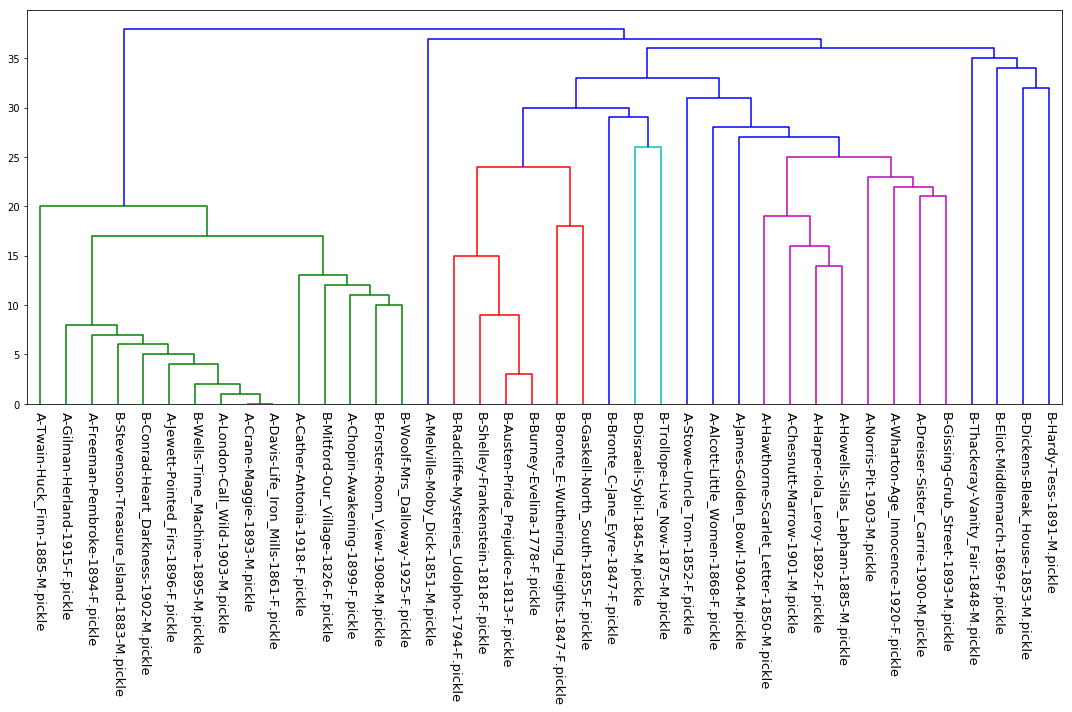

CPU times: user 48.6 s, sys: 703 ms, total: 49.3 s
Wall time: 50.1 s


In [ ]:
%%time
labels = []
label_by = 'files' # Label leaves by file name; use 'terms' to label by most common terms

for fileid in corpus.fileids(categories=['AF', 'AM', 'BF', 'BM']):
    if label_by=='terms':
        terms = []
        for term, count in Counter(list(normalize(corpus.tagged(fileid)))).most_common(10):
            terms.append(term)
        labels.append(terms)
    else:
        labels.append(fileid)

clusterer = HierarchicalTopics(corpus)
clusterer.cluster(corpus)
clusterer.plot_dendrogram(labels=labels, leaf_font_size=13)

## LDA topic modeling

### sklearn

In [ ]:
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD, NMF
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin

def identity(words):
    return words

class TextNormalizer(BaseEstimator, TransformerMixin):

    def __init__(self, language='english'):
        self.stopwords  = set(nltk.corpus.stopwords.words(language))
        self.lemmatizer = nltk.WordNetLemmatizer()

    def is_punct(self, token):
        return all(
            unicodedata.category(char).startswith('P') for char in token
        )

    def is_stopword(self, token):
        return token.lower() in self.stopwords

    def normalize(self, document):
        return [
            self.lemmatize(token, tag).lower()
            for paragraph in document
            for sentence in paragraph
            for (token, tag) in sentence
            if not self.is_punct(token) and not self.is_stopword(token)
        ]

    def lemmatize(self, token, pos_tag):
        tag = {
            'N': wn.NOUN,
            'V': wn.VERB,
            'R': wn.ADV,
            'J': wn.ADJ
        }.get(pos_tag[0], wn.NOUN)

        return self.lemmatizer.lemmatize(token, tag)

    def fit(self, X, y=None):
        return self

    def transform(self, documents):
        return [
            self.normalize(document)
            for document in documents
        ]

class SklearnTopicModels(object):

    def __init__(self, n_components=50, estimator='LDA'):
        """
        n_topics is the desired number of topics
        To use Latent Semantic Analysis, set estimator to 'LSA',
        To use Non-Negative Matrix Factorization, set estimator to 'NMF',
        otherwise, defaults to Latent Dirichlet Allocation ('LDA').
        """
        self.n_components = n_components

        if estimator == 'LSA':
            self.estimator = TruncatedSVD(n_components=self.n_components)
        elif estimator == 'NMF':
            self.estimator = NMF(n_components=self.n_components)
        else:
            self.estimator = LatentDirichletAllocation(n_components=self.n_components)

        self.model = Pipeline([
            ('norm', TextNormalizer()),
            ('tfidf', CountVectorizer(
                tokenizer=identity, 
                preprocessor=None, 
                lowercase=False,
                min_df=0.05,
                max_df=0.80
            )),
            ('model', self.estimator)
        ])


    def fit_transform(self, documents):
        self.model.fit_transform(documents)

        return self.model


    def get_topics(self, n=25):
        """
        n is the number of top terms to show for each topic
        """
        vectorizer = self.model.named_steps['tfidf']
        model = self.model.steps[-1][1]
        names = vectorizer.get_feature_names()
        topics = dict()

        for idx, topic in enumerate(model.components_):
            features = topic.argsort()[:-(n - 1): -1]
            tokens = [names[i] for i in features]
            topics[idx] = tokens

        return topics

In [ ]:
%%time
skmodel = SklearnTopicModels(estimator='LDA', n_components=10)
documents = corpus.docs()

skmodel.fit_transform(documents)
topics = skmodel.get_topics()
for topic, terms in topics.items():
    print("Topic #{}:".format(topic+1))
    print(terms)

Topic #1:
['dorothea', 'felix', 'rosamond', 'fred', 'richard', 'roger', 'leicester', 'paul', 'guardian', 'george', 'bucket', 'london', 'mary', 'montague', 'ada', 'brooke', 'ruby', 'marie', 'john', 'hurtle', 'dolly', 'james', 'chapter']
Topic #2:
['lapham', 'laura', 'archer', 'wheat', 'madame', 'colonel', 'penelope', 'york', 'toward', 'grandmother', 'beaufort', 'pit', 'van', 'rogers', 'em', 'ellen', 'der', 'dollar', 'aunt', 'million', 'pen', 'market', 'tom']
Topic #3:
['marian', 'de', 'amy', 'jasper', 'negro', 'ter', 'dat', 'dr', 'carteret', 'robert', 'delamere', 'miller', 'tom', 'dora', 'sandy', 'ellis', 'yer', 'colored', 'clare', 'fer', 'er', 'dey', 'major']
Topic #4:
['emily', 'charlotte', 'st', 'madame', 'annette', 'chamber', 'barney', 'hester', 'linton', 'castle', 'catherine', 'endeavour', 'thou', 'aunt', 'apartment', 'sylvia', 'pearl', 'chateau', 'minister', 'quit', 'rose', 'signor', 'rebecca']
Topic #5:
['carrie', 'elizabeth', 'bennet', 'bingley', 'jane', 'wickham', 'collins', 'm

### Gensim

In [ ]:
from gensim.sklearn_api import lsimodel, ldamodel
from gensim.matutils import sparse2full
from gensim.corpora import Dictionary
from gensim.models.tfidfmodel import TfidfModel
from gensim.sklearn_api import lsimodel, ldamodel

class GensimTfidfVectorizer(BaseEstimator, TransformerMixin):

    def __init__(self, dirpath=".", tofull=False):
        """
        Pass in a directory that holds the lexicon in corpus.dict and the
        TFIDF model in tfidf.model (for now).

        Set tofull = True if the next thing is a Scikit-Learn estimator
        otherwise keep False if the next thing is a Gensim model.
        """
        self._lexicon_path = os.path.join(dirpath, "corpus.dict")
        self._tfidf_path = os.path.join(dirpath, "tfidf.model")

        self.lexicon = None
        self.tfidf = None
        self.tofull = tofull

        self.load()

    def load(self):

        if os.path.exists(self._lexicon_path):
            self.lexicon = Dictionary.load(self._lexicon_path)

        if os.path.exists(self._tfidf_path):
            self.tfidf = TfidfModel().load(self._tfidf_path)

    def save(self):
        self.lexicon.save(self._lexicon_path)
        self.tfidf.save(self._tfidf_path)

    def fit(self, documents, labels=None):
        self.lexicon = Dictionary(documents)
        self.tfidf = TfidfModel(
            [self.lexicon.doc2bow(doc) for doc in documents], 
            id2word=self.lexicon
        )
        self.save()
        return self

    def transform(self, documents):
        def generator():
            for document in documents:
                vec = self.tfidf[self.lexicon.doc2bow(document)]
                if self.tofull:
                    yield sparse2full(vec)
                else:
                    yield vec
        return list(generator())

class GensimTopicModels(object):

    def __init__(self, n_topics=50, estimator='LDA'):
        """
        n_topics is the desired number of topics

        To use Latent Semantic Analysis, set estimator to 'LSA'
        otherwise defaults to Latent Dirichlet Allocation.
        """
        self.n_topics = n_topics

        if estimator == 'LSA':
            self.estimator = lsimodel.LsiTransformer(num_topics=self.n_topics)
        else:
            self.estimator = ldamodel.LdaTransformer(num_topics=self.n_topics)

        self.model = Pipeline([
            ('norm', TextNormalizer()),
            ('vect', GensimTfidfVectorizer()),
            ('model', self.estimator)
        ])

    def fit(self, documents):
        self.model.fit(documents)

        return self.model

In [ ]:
%%time
import warnings

corpus_chunked = PickledCorpusReader(pkl_chk_dir)
gmodel = GensimTopicModels(estimator='LDA', n_topics=10)
docs = [
    list(corpus_chunked.docs(fileids=fileid))[0]
    for fileid in corpus_chunked.fileids()
]

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    gmodel.fit(docs)

In [ ]:
# retrieve the fitted lda model from the named steps of the pipeline
lda = gmodel.model.named_steps['model'].gensim_model

# Recreate the processed corpus
corpus = [
    gmodel.model.named_steps['vect'].lexicon.doc2bow(doc)
    for doc in gmodel.model.named_steps['norm'].transform(docs)
]

# Get the lexicon
lexicon = gmodel.model.named_steps['vect'].lexicon

In [ ]:
%%time 
import pyLDAvis
import pyLDAvis.gensim

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    data = pyLDAvis.gensim.prepare(lda, corpus, lexicon)

In [ ]:
pyLDAvis.display(data)